In [23]:
# =================== 1. Setup Spark and Import Libraries ===================
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import *
from pyspark.sql.functions import *
from pyspark.ml import PipelineModel
from pyspark.ml.feature import *
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, Row, StructType
from pyspark.sql.functions import col
from math import pi, cos, sin
import os
from pyspark.sql.dataframe import DataFrame
from pyspark.sql import SparkSession
import json
from pyspark.ml import Pipeline
# ML Imports
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator



TARGET_COLUMN = "ArrDelay"
# Path to Parquet file
FLIGHT_PARQUET_PATH = './data/flights.parquet'
PLANES_PARQUET_PATH = './data/planes.parquet'
PROCESSING_DIR = "data/processing/"
# Path to schema file
PLANE_SCHEMA_PATH = './data/plane-schema.json'
FLIGHT_SCHEMA_PATH = './data/flight-schema.json'
# Load paths
FLIGHT_RAW_PATH = './data/2008.csv.bz2'
PLANE_RAW_PATH = './data/plane-data.csv'
# Result paths
PROCESSED_DIR = './data/processed/'
PROCESSED_TRAIN_PARQUET = os.path.join(PROCESSED_DIR, "train.parquet")
PROCESSED_TEST_PARQUET = os.path.join(PROCESSED_DIR, "test.parquet")
PROCESSED_SCHEMA = os.path.join(PROCESSED_DIR, "schema.json")

In [2]:
# --- 2. Function to Force Clean Cache ---
def clean_cached_data_force():
    paths = [
        './data/flights.parquet', 
        './data/planes.parquet', 
        './data/processed/train.parquet', 
        './data/processed/test.parquet',
        './data/processed/schema.json',
        './data/imputer_maps.json',
        './data/encode_types.json'
    ]
    print("--- FORCING CLEANUP OF OLD DATA ---")
    for p in paths:
        if os.path.exists(p):
            if os.path.isdir(p): shutil.rmtree(p)
            else: os.remove(p)
            print(f"Deleted: {p}")
    print("--- CLEANUP COMPLETE ---")

# --- EXECUTE PIPELINE ---
# First, clean to force regeneration of Parquet files with the new logic
clean_cached_data_force()

--- FORCING CLEANUP OF OLD DATA ---
--- CLEANUP COMPLETE ---


--- Analyzing Raw File: ./data/2008.csv.bz2 ---


Total Rows: 2389217
Computing statistics (this may take a minute)...



--- Data Quality Summary ---
         Variable  Total_Bad_Data  Percent_Bad
0        ArrDelay           70096     2.933848
1        DepDelay           64442     2.697202
2        Distance               0     0.000000
3         TaxiOut           64442     2.697202
4  CRSElapsedTime             407     0.017035
5       Cancelled               0     0.000000
6         AirTime           70096     2.933848


<Figure size 1400x800 with 0 Axes>

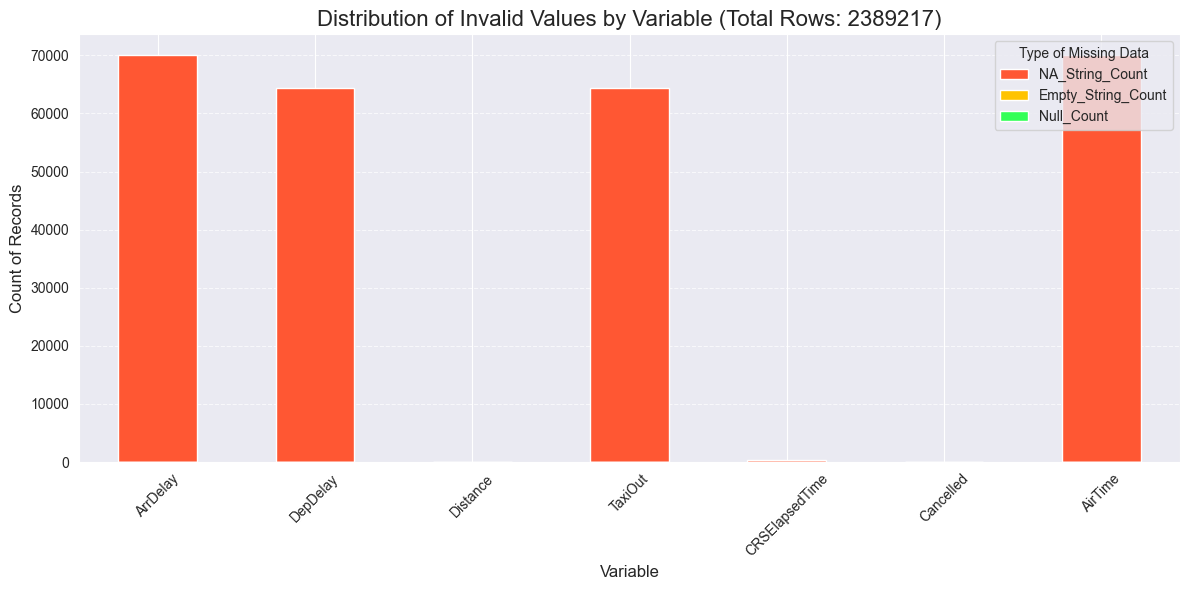

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

def analyze_missing_values(spark, file_path):
    """
    Analyzes and visualizes the distribution of 'NA', empty strings, and Null values
    in the raw dataset.
    """
    print(f"--- Analyzing Raw File: {file_path} ---")
    
    # READ AS RAW TEXT (Disable schema inference to capture 'NA' strings)
    # We set inferSchema=False to prevent Spark from failing on load
    df_raw = spark.read.option("header", "true") \
                       .option("inferSchema", "false") \
                       .csv(file_path)
    
    total_rows = df_raw.count()
    print(f"Total Rows: {total_rows}")
    
    # Columns suspected of causing issues (Quantitative + Target + Cancelled)
    target_cols = [
        'ArrDelay', 'DepDelay', 'Distance', 'TaxiOut', 
        'CRSElapsedTime', 'Cancelled', 'AirTime'
    ]
    
    stats = []
    
    print("Computing statistics (this may take a minute)...")
    for col_name in target_cols:
        # Check if column exists to avoid errors
        if col_name not in df_raw.columns:
            continue
            
        # Count 3 types of "bad" data
        # 1. Explicit "NA" string
        na_count = df_raw.filter(F.col(col_name) == "NA").count()
        
        # 2. Empty or whitespace strings
        empty_count = df_raw.filter(F.trim(F.col(col_name)) == "").count()
        
        # 3. True Nulls
        null_count = df_raw.filter(F.col(col_name).isNull()).count()
        
        stats.append({
            "Variable": col_name,
            "NA_String_Count": na_count,
            "Empty_String_Count": empty_count,
            "Null_Count": null_count,
            "Valid_Data_Count": total_rows - (na_count + empty_count + null_count)
        })
    
    # Convert to Pandas for Plotting
    pdf = pd.DataFrame(stats)
    
    # Calculate percentages
    pdf["Total_Bad_Data"] = pdf["NA_String_Count"] + pdf["Empty_String_Count"] + pdf["Null_Count"]
    pdf["Percent_Bad"] = (pdf["Total_Bad_Data"] / total_rows) * 100
    
    print("\n--- Data Quality Summary ---")
    print(pdf[["Variable", "Total_Bad_Data", "Percent_Bad"]])
    
    # --- PLOTTING ---
    plt.figure(figsize=(14, 8))
    
    # Prepare data for Stacked Bar Chart
    plot_data = pdf.set_index("Variable")[["NA_String_Count", "Empty_String_Count", "Null_Count"]]
    
    plot_data.plot(kind='bar', stacked=True, color=['#FF5733', '#FFC300', '#33FF57'], figsize=(12, 6))
    
    plt.title(f"Distribution of Invalid Values by Variable (Total Rows: {total_rows})", fontsize=16)
    plt.ylabel("Count of Records", fontsize=12)
    plt.xlabel("Variable", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="Type of Missing Data")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# --- EXECUTE ---
# Note: Ensure you point to the raw .csv.bz2 file, NOT the parquet
file_path = './data/2008.csv.bz2' 

# Get active Spark session
analyze_missing_values(SparkSession.builder.getOrCreate(), file_path)

In [3]:
# =================== 1. Data Reading ===================
def load_data(spark, input_path, mode):
    """
    Load the input dataset, drop forbidden columns, and validate its structure.

    Args:
        spark (SparkSession): The active Spark session.
        input_path (str): Path to the input CSV file.
        mode (str): Mode of operation ("train" or "predict").

    Returns:
        DataFrame: Processed Spark DataFrame.
    """
    forbidden_columns = [
        "ArrTime", "ActualElapsedTime", "AirTime", "TaxiIn", "Diverted",
        "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"
    ]

    try:
        # Read the dataset
        data = spark.read.csv(input_path, header=True, inferSchema=True, nullValue="NA")

        # Drop forbidden columns
        data = data.drop(*forbidden_columns)

        # Check if the dataset is empty
        if data.count() == 0:
            raise ValueError("The dataset is empty.")

        # Validate the presence of the target variable for training
        if mode == "train" and "ArrDelay" not in data.columns:
            raise ValueError("The target variable 'ArrDelay' is missing.")

    except Exception as e:
        print(f"Error reading the dataset: {e}")
        spark.stop()
        raise

    return data

In [4]:
import shutil
import os
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, when, expr

# --- 1. ROBUST CASTING FUNCTION ---
def cast_columns_safely(df, columns, target_type="int"):
    """
    Safely casts specified columns to the target type using 'try_cast'.
    If a value is 'NA', empty, or malformed, it returns NULL instead of raising an error.
    
    Args:
        df: Input Spark DataFrame.
        columns: List of column names to cast.
        target_type: Target SQL data type (e.g., 'int', 'double').
    
    Returns:
        DataFrame with cast columns.
    """
    for column_name in columns:
        # F.expr("try_cast(...)") delegates safe casting to Spark SQL.
        # It handles 'NA', whitespace, and text automatically by converting them to NULL.
        df = df.withColumn(column_name, F.expr(f"try_cast({column_name} as {target_type})"))
    return df

# --- 2. REDEFINED STATIC_PREPROCESS ---
def static_preprocess(df, df_planes):
    """
    Performs static preprocessing: renaming, joining, filtering, and safe type casting.
    """
    # Standardize column names & Join
    df_planes = df_planes.withColumnRenamed("tailnum", "TailNum")
    df = df.join(df_planes, on="TailNum", how="inner")

    # Filter Cancelled flights
    # Casting to string first to avoid type mismatches
    df = df.withColumn("Cancelled", F.col("Cancelled").cast("string"))
    df = df.filter(F.col("Cancelled") != "1")

    # Drop forbidden or leakage columns
    forbidden_cols = [
        "ArrTime", "ActualElapsedTime", "AirTime", "TaxiIn", "Diverted",
        "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"
    ]
    df = df.drop(*forbidden_cols)

    target_column = "ArrDelay"

    # Feature lists
    cyclic_ordinal_time = ['Month', 'DayofMonth', 'DayOfWeek']
    non_cyclic_ordinal_time = ['Year', 'PlaneIssueYear']
    quant_time_features = ['DepTime', 'CRSDepTime', 'CRSArrTime']
    quantitative_features = ['CRSElapsedTime', 'DepDelay', 'Distance', 'TaxiOut']
    
    nominal_features = [
        'UniqueCarrier', 'FlightNum', 'TailNum', 'Origin', 'Dest', 'Cancelled',
        'CancellationCode', 'EngineType', 'AircraftType', 'Manufacturer', 'Model',
        "issue_date", "status", "type"
    ]

    # Clean up useless nominal features
    useless_features = ["TailNum", "FlightNum", "UniqueCarrier", "CancellationCode", "Cancelled", "issue_date", "status", "type"]
    for fea in useless_features:
        if fea in nominal_features: nominal_features.remove(fea)
    df = df.drop(*useless_features)

    # Rename columns for consistency
    df = df.withColumnRenamed("year", "PlaneIssueYear")
    df = df.withColumnRenamed("engine_type", "EngineType")
    df = df.withColumnRenamed("aircraft_type", "AircraftType")
    df = df.withColumnRenamed("model", "Model")
    df = df.withColumnRenamed("manufacturer", "Manufacturer")

    # --- CRITICAL FIX APPLIED HERE ---
    print("Sanitizing and casting quantitative columns safely...")
    
    # 1. Clean quantitative features and target using try_cast
    # This converts "NA" to NULL before any math operation
    cols_to_clean = quantitative_features + [target_column]
    df = cast_columns_safely(df, cols_to_clean, target_type="int")
    
    # 2. Filter null targets (Safe now because 'NA' strings are converted to NULL)
    print(f"Filtering rows with null {target_column}...")
    df = df.dropna(subset=[target_column])
    
    # 3. Process time columns (Handling 'NA' in time strings)
    print("Sanitizing time columns...")
    
    # First, ensure 'NA' strings in time columns are converted to NULL
    for col_time in quant_time_features:
        df = df.withColumn(col_time, F.when(F.trim(F.col(col_time)) == "NA", None).otherwise(F.col(col_time)))
        
    for column in quant_time_features:
        print(f"Processing time column {column}...")
        # Use try_cast on substrings to safely parse HHMM format
        df = df.withColumn(
            column + "_minutes",
            (F.expr(f"try_cast(substring({column}, 1, 2) as int)") * 60 + 
             F.expr(f"try_cast(substring({column}, 3, 2) as int)"))
        )
        # Fill resulting nulls (invalid times) with 0 or drop them
        df = df.fillna(0, subset=[column + "_minutes"])
        quantitative_features.append(column + "_minutes")
    
    df = df.drop(*quant_time_features)

    # Feature Engineering (Polar coordinates)
    # Ensure 'custom_polar_time_encode' is defined in your notebook
    df = custom_polar_time_encode(df)
    
    ordinal_features = []
    ordinal_features += [fea + "_sin" for fea in cyclic_ordinal_time]
    ordinal_features += [fea + "_cos" for fea in cyclic_ordinal_time]

    return df, quantitative_features, ordinal_features, nominal_features + non_cyclic_ordinal_time


In [5]:
# =================== 2. Exploratory Data Analysis (EDA) ===================
def eda(data):
    """
    Perform exploratory data analysis on the dataset, including univariate and multivariate analysis.

    Args:
        data (DataFrame): Spark DataFrame to analyze.

    Returns:
        DataFrame: DataFrame with a feature vector column added for further processing.
    """
    # Univariate analysis: Display statistical summary
    print("Statistical Summary:")
    data.describe().show()

    # Multivariate analysis: Correlations and patterns
    # Select numeric columns for correlation analysis
    numeric_cols = [col for col, dtype in data.dtypes if dtype in ('int', 'double')]

    if numeric_cols:
        # Assemble numeric columns into a single feature vector
        vector_col = "features_vector"
        assembler = VectorAssembler(inputCols=numeric_cols, outputCol=vector_col)
        data = assembler.transform(data)

        # Display correlation matrix for the numeric features
        from pyspark.ml.stat import Correlation
        try:
            correlation_matrix = Correlation.corr(data, vector_col).head()[0]
            print(f"Correlation matrix:\n{correlation_matrix}")
        except Exception as e:
            print(f"Error calculating correlations: {e}")
    else:
        print("No numeric columns available for correlation analysis.")

    return data

In [26]:
import json
import os
import shutil
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType, StringType
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col, when, lit
from pyspark.sql import SparkSession

# --- 1. TRAIN_PREPROCESS (Updated to save feature list safely) ---
def train_preprocess(df, nominal_features, ordinal_features, quantitative_features, dir_save_params,
                     cardinality_threshold, frequency_threshold, high_cardinality_strategy):
    """
    Calculates preprocessing parameters and saves them.
    Now saves 'feature_columns.json' to ensure VectorAssembler works correctly.
    """
    spark = SparkSession.builder.getOrCreate()
    
    print("Analyzing medians and modes...")
    imputer_maps = {}
    
    # Quantitative Imputation
    for fea in quantitative_features:
        median = df.approxQuantile(col=fea, probabilities=[0.5], relativeError=0.025)[0]
        imputer_maps[fea] = {'extra_nulls': [], 'fill_value': median}
    
    # Ordinal/Nominal Imputation
    for fea in ordinal_features + nominal_features:
        # Check type to avoid 'None' string errors on numerics
        is_string = isinstance(df.schema[fea].dataType, StringType)
        extra_nulls = ['None'] if is_string else []
        
        mode_row = df.groupby(fea).count().orderBy("count", ascending=False).first()
        fill_val = mode_row[0] if mode_row is not None else 0
        imputer_maps[fea] = {'extra_nulls': extra_nulls, 'fill_value': fill_val}

    # Save Imputer Maps
    with open(os.path.join(dir_save_params, 'imputer_maps.json'), 'w') as f:
        f.write(json.dumps(imputer_maps, indent=4))

    # --- NOMINAL ENCODING ---
    feature_to_sufficiently_frequent = {}
    total_count = df.count()
    
    for fea in nominal_features:
        # Find frequent categories
        freq_rows = df.groupBy(fea).agg((F.count("*") / total_count).alias("freq"))\
                      .filter(F.col("freq") > frequency_threshold)\
                      .select(fea).collect()
        feature_to_sufficiently_frequent[fea] = [row[fea] for row in freq_rows]

    nominal_encode_type = {}
    new_nominal = []
    
    for fea in nominal_features:
        valid_cats = feature_to_sufficiently_frequent[fea]
        # Create temp column for fitting
        df_temp = df.withColumn(f"{fea}_aggregated", 
                                F.when(F.col(fea).isin(valid_cats), F.col(fea)).otherwise(lit("Other")))
        
        if len(valid_cats) + 1 <= cardinality_threshold:
            print(f"One-Hot-Encoding feature: {fea}")
            indexer = StringIndexer(inputCol=f"{fea}_aggregated", outputCol=f"{fea}_index", handleInvalid='keep')
            encoder = OneHotEncoder(inputCol=f"{fea}_index", outputCol=f"{fea}_binary", handleInvalid='keep', dropLast=True)
            
            pipeline = Pipeline(stages=[indexer, encoder])
            pipeline_model = pipeline.fit(df_temp)
            pipeline_model.save(os.path.join(dir_save_params, f'{fea}_aggregated_encoder'))
            
            nominal_encode_type[f"{fea}_aggregated"] = "binary"
            new_nominal.append(f"{fea}_binary")
            
        elif high_cardinality_strategy == "mean":
            print(f"Mean-Target-Encoding feature: {fea}")
            mapping = df_temp.groupBy(f"{fea}_aggregated").agg(F.avg("ArrDelay").alias("mean_target"))
            
            # Add global mean for 'Other' if missing
            if mapping.filter(F.col(f"{fea}_aggregated") == "Other").count() == 0:
                global_mean = df.select(F.avg("ArrDelay")).collect()[0][0]
                mapping = mapping.union(spark.createDataFrame([("Other", float(global_mean))], mapping.schema))
                
            mapping.write.mode("overwrite").csv(os.path.join(dir_save_params, f'{fea}_aggregated_encoder.csv'), header=True)
            
            nominal_encode_type[f"{fea}_aggregated"] = "mean"
            new_nominal.append(f"{fea}_mean_enc")

    # Save Metadata
    with open(os.path.join(dir_save_params, 'encode_types.json'), 'w') as f:
        f.write(json.dumps(nominal_encode_type, indent=4))
    with open(os.path.join(dir_save_params, 'non_aggregated.json'), 'w') as f:
        f.write(json.dumps(feature_to_sufficiently_frequent, indent=4))
        
    # --- SAVE FEATURE LIST ---
    # Save the list of columns to be vectorized later
    final_features = quantitative_features + ordinal_features + new_nominal
    with open(os.path.join(dir_save_params, 'feature_columns.json'), 'w') as f:
        json.dump(final_features, f)
    print("Training preprocessing complete. Parameters saved.")


# --- 2. DYNAMIC_PREPROCESS (Fixed Collision Error) ---
def dynamic_preprocess(df, nominal_features, ordinal_features, quantitative_features, dir_load_params):
    """
    Applies preprocessing using saved parameters.
    Fixes: Renames 'mean_target' before joining to avoid AnalysisException.
    """
    spark = SparkSession.builder.getOrCreate()
    
    # 1. IMPUTER
    with open(os.path.join(dir_load_params, 'imputer_maps.json'), 'r') as f:
        imputer_maps = json.load(f)

    for fea in quantitative_features + ordinal_features + nominal_features:
        if fea not in df.columns: continue
        
        dtype = df.schema[fea].dataType
        is_numeric = isinstance(dtype, (IntegerType, DoubleType))
        extra_nulls = imputer_maps[fea]['extra_nulls']
        valid_extra_nulls = [x for x in extra_nulls if not isinstance(x, str)] if is_numeric else extra_nulls

        if len(valid_extra_nulls) > 0:
            df = df.withColumn(fea, when(df[fea].isin(valid_extra_nulls), lit(None)).otherwise(df[fea]))

        if df.filter(col(fea).isNull()).count() > 0:
            df = df.fillna(imputer_maps[fea]['fill_value'], subset=[fea])

    # 2. NOMINAL ENCODER
    with open(os.path.join(dir_load_params, 'encode_types.json'), 'r') as f:
        encode_types = json.load(f)
    with open(os.path.join(dir_load_params, 'non_aggregated.json'), 'r') as f:
        fea_freqs = json.load(f)

    for fea, valid_cats in fea_freqs.items():
        if fea in df.columns:
            df = df.withColumn(f"{fea}_aggregated", 
                               F.when(F.col(fea).isin(valid_cats), F.col(fea)).otherwise(lit("Other")))

    for agg_fea, method in encode_types.items():
        original_fea = agg_fea.replace("_aggregated", "")
        
        if method == 'binary':
            path = os.path.join(dir_load_params, f'{original_fea}_aggregated_encoder')
            if os.path.exists(path):
                model = PipelineModel.load(path)
                df = model.transform(df)
                
        elif method == 'mean':
            path = os.path.join(dir_load_params, f'{original_fea}_aggregated_encoder.csv')
            if os.path.exists(path):
                mapping = spark.read.csv(path, header=True, inferSchema=True)
                
                # CRITICAL FIX: Rename column BEFORE join to prevent collision
                mean_col_name = f"{original_fea}_mean_enc"
                mapping = mapping.withColumnRenamed("mean_target", mean_col_name)
                
                # Join
                df = df.join(mapping, on=agg_fea, how='left')
                
                # Fill missing
                other_val_row = mapping.filter(F.col(agg_fea) == "Other").select(mean_col_name).collect()
                if other_val_row:
                    fill_val = other_val_row[0][0]
                    df = df.fillna(fill_val, subset=[mean_col_name])

    # 3. VECTORIZER (Using saved list)
    cols_path = os.path.join(dir_load_params, 'feature_columns.json')
    if os.path.exists(cols_path):
        with open(cols_path, 'r') as f:
            final_features = json.load(f)
        
        # Filter only existing columns to be safe
        available_cols = [c for c in final_features if c in df.columns]
        
        assembler = VectorAssembler(
            inputCols=available_cols,
            outputCol="features",
            handleInvalid="skip"
        )
        df = assembler.transform(df)
    
    return df

In [27]:
def load_csv_save_parquet(spark, raw_path, parquet_path, schema_path) -> DataFrame:
    """
    Reads a CSV file using Spark, saves its schema to a file, and converts the data to Parquet format.

    Parameters:
    spark: SparkSession object
    raw_path: str - Path to the raw CSV file
    parquet_path: str - Path where the Parquet file will be saved
    schema_path: str - Path where the schema JSON will be saved

    Returns:
    DataFrame: Spark DataFrame loaded from the saved Parquet file
    """
    # Read csv
    df = spark.read.csv(
        raw_path,
        header=True,
        inferSchema=True,
        nullValue="NA"
    )

    schema = df.schema
    schema_json = schema.json()

    # Write the schema JSON to a file
    with open(schema_path, 'w') as f:
        f.write(schema_json)

    # Save DataFrame as Parquet for future use
    df.repartition(1)
    df.write.parquet(parquet_path)

    df = spark.read.parquet(parquet_path, schema=schema)
    return df

def load_parquet(spark, parquet_path, schema_file) -> DataFrame:
    """
    Loads a Parquet file using a predefined schema from a JSON file.

    Parameters:
    spark: SparkSession object
    parquet_path: str - Path to the Parquet file
    schema_file: str - Path to the schema JSON file

    Returns:
    DataFrame: Spark DataFrame with the specified schema
    """
    with open(schema_file, 'r') as f:
        schema_json = f.read()

    # Deserialize the JSON string back into a StructType object
    schema_from_file = StructType.fromJson(json.loads(schema_json))

    df = spark.read.parquet(parquet_path, schema=schema_from_file)
    return df

def load(spark, parquet_path, schema_file_path, wildcard_path) -> (DataFrame, DataFrame):
    """
    Loads data either from existing Parquet files or from raw CSV files if Parquet doesn't exist.

    Parameters:
    spark: SparkSession object
    parquet_path: str - Path to the Parquet file
    schema_file_path: str - Path to the schema file
    wildcard_path: str - Path pattern for raw CSV files

    Returns:
    tuple(DataFrame, DataFrame): Tuple containing main DataFrame and planes DataFrame
    """
    if os.path.exists(parquet_path):
        # If Parquet exists, load it using the schema files
        df = load_parquet(spark, parquet_path, schema_file_path)
        df_planes = load_parquet(spark, PLANES_PARQUET_PATH, PLANE_SCHEMA_PATH)
    else:
        # If Parquet file does not exist, read CSV files and save as Parquet
        df = load_csv_save_parquet(spark, wildcard_path, parquet_path, schema_file_path)
        df_planes = load_csv_save_parquet(spark, PLANE_RAW_PATH, PLANES_PARQUET_PATH, PLANE_SCHEMA_PATH)
    return df, df_planes

def custom_polar_time_encode(df):
    """
    Transforms Month, DayofMonth, and DayofWeek columns into polar coordinates.

    Parameters:
    df: DataFrame - Input Spark DataFrame

    Returns:
    DataFrame: DataFrame with added polar coordinate columns and original time columns dropped
    """
    print(f"Transforming Month, DayofMonth and DayofWeek to polar coordinates.")

    def polar_encoding(value, max_value):
        frac = value / max_value
        circle = 2 * pi
        angle = frac * circle
        return cos(angle), sin(angle)

    # Register UDF for polar encoding
    polar_udf = udf(polar_encoding, "struct<cos:double, sin:double>")

    # Apply polar encoding on 'Month', 'DayofMonth', 'DayOfWeek'
    df = df.withColumn("Month_polar", polar_udf(col("Month"), lit(12))) \
        .withColumn("DayofMonth_polar", polar_udf(col("DayofMonth"),
                                                  when(col("Month") == 2, lit(28))  # February (can adjust for leap year
                                                  # if needed)
                                                  .when(col("Month").isin([4, 6, 9, 11]),
                                                        lit(30))  # Months with 30 days
                                                  .otherwise(lit(31)))) \
        .withColumn("DayOfWeek_polar", polar_udf(col("DayOfWeek"), lit(7)))

    # Subdivide feature pairs into two columns each
    df = df.withColumn("Month_cos", col("Month_polar.cos")) \
        .withColumn("Month_sin", col("Month_polar.sin")) \
        .withColumn("DayofMonth_cos", col("DayofMonth_polar.cos")) \
        .withColumn("DayofMonth_sin", col("DayofMonth_polar.sin")) \
        .withColumn("DayOfWeek_cos", col("DayOfWeek_polar.cos")) \
        .withColumn("DayOfWeek_sin", col("DayOfWeek_polar.sin"))

    df = df.drop(*["DayofMonth_polar", "DayOfWeek_polar", "Month_polar"])

    return df

def assure_existence_directory(directory_path):
    """
    Creates a directory if it doesn't exist.

    Parameters:
    directory_path: str - Path to the directory to create
    """
    # Check if the directory exists
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)


def preprocess_fit_and_transform(df, df_planes, dir_save_params):
    """
    Orchestrates the preprocessing:
    1. Static cleaning.
    2. Learning parameters (Train) if they don't exist.
    3. Applying parameters (Dynamic) - MANDATORY step.
    """
    # 1. Static Preprocessing (Cleaning, casting, basic joins)
    df, quantitative, ordinal, nominal = static_preprocess(df, df_planes)
    
    # 2. Check if we need to train params or load them
    # We check for a key file to decide
    feature_cols_path = os.path.join(dir_save_params, 'feature_columns.json')
    params_exist = os.path.exists(feature_cols_path)
    
    if not params_exist:
        print("TRAINING PREPROCESSING PARAMETERS (Learning Mode)...")
        # Learn and save parameters to JSON
        train_preprocess(df, nominal, ordinal, quantitative, dir_save_params, 
                         cardinality_threshold=10, frequency_threshold=0.02, high_cardinality_strategy="mean")
    else:
        print("PARAMETERS FOUND (Loading Mode). Skipping Learning.")
        
    # 3. CRITICAL FIX: Always Apply Dynamic Preprocess
    # This creates the 'features' column using VectorAssembler
    print("Applying dynamic preprocessing transformations...")
    df = dynamic_preprocess(df, nominal, ordinal, quantitative, dir_save_params)
    
    return df


def split_and_preprocess(df, df_planes, train_frac=0.8, dir_save_params="./data/"):
    """
    Splits data and ensures BOTH Train and Test sets get the 'features' column.
    """
    # Split raw data
    train_df, test_df = df.randomSplit([train_frac, 1 - train_frac], seed=42)
    
    # A. Process Training Data
    print("--- Processing Training Data ---")
    # This will learn params AND apply them (creating 'features')
    train_df = preprocess_fit_and_transform(train_df, df_planes, dir_save_params)
    
    # B. Process Test Data
    print("--- Processing Test Data ---")
    # 1. Static Clean
    test_df, quantitative, ordinal, nominal = static_preprocess(test_df, df_planes)
    # 2. Dynamic Apply (using params learned from Train)
    test_df = dynamic_preprocess(test_df, nominal, ordinal, quantitative, dir_save_params)
    
    return train_df, test_df


# THIS IS THE FUNCTION TO USE TO PREPROCESS VALIDATION DATA PASSED THROUGH CONSOLE <-------------------------------------
def validation_preprocess(df, dir_save_params="./data/"):
    """
    Preprocesses validation data using saved parameters from training.

    Parameters:
    df: DataFrame - Input validation data
    dir_save_params: str - Directory containing preprocessing parameters

    Returns:
    DataFrame: Preprocessed validation DataFrame
    """
    spark = SparkSession.builder.appName("BigDataFlightDelayProject").getOrCreate()
    df_planes = load_parquet(spark, PLANES_PARQUET_PATH, PLANE_SCHEMA_PATH)
    df, quantitative_features, ordinal_features, nominal_features = static_preprocess(df, df_planes)
    df = dynamic_preprocess(df, nominal_features, ordinal_features, quantitative_features, dir_save_params)
    return df


def load_split_and_preprocess(n_partitions=10, debug=False):
    """
    Complete pipeline for loading, splitting, and preprocessing data.
    Handles both initial processing and loading of previously processed data.

    Parameters:
    n_partitions: int - Number of partitions for Spark DataFrame
    debug: bool - If True, uses a small fraction of data for debugging
    """
    spark = (SparkSession.builder.appName("BigDataFlightDelayProject") # Change this as needed
             .config("spark.executor.memory", "4g")
             .config("spark.driver.memory", "48g")
             .config("spark.memory.fraction", "0.8")
             .config("spark.memory.storageFraction", "0.3")
             .config("spark.driver.maxResultSize", "4g")
             .config("spark.sql.caseSensitive", "true")
             .config("spark.sql.debug.maxToStringFields", "200")
             # .config("spark.local.dir", "./temp/")
             .getOrCreate())

    if not os.path.exists(PROCESSED_TRAIN_PARQUET):
        df, df_planes = load(spark, FLIGHT_PARQUET_PATH, PLANE_SCHEMA_PATH, FLIGHT_RAW_PATH)
        df = df.repartition(n_partitions)

        if debug:
            fraction = 0.01  # Adjust the fraction to select 10% of rows
            df = df.sample(withReplacement=True, fraction=fraction)
            df = df.repartition(1)

        # train_df, test_df = complete_preprocess(df, df_planes, train_frac=0.8)
        assure_existence_directory(PROCESSING_DIR)
        train_df, test_df = split_and_preprocess(df, df_planes, train_frac=0.8, dir_save_params=PROCESSING_DIR)
        print("Finished preprocessing")
        print(train_df.head())
        print(test_df.head())

        print(f"Saving schema to {PROCESSED_SCHEMA}")
        assure_existence_directory(PROCESSED_DIR)
        schema_json = train_df.schema.json()
        with open(PROCESSED_SCHEMA, 'w') as f:
            f.write(schema_json)
        test_df.write.mode('overwrite').parquet(PROCESSED_TEST_PARQUET)
        train_df.write.mode('overwrite').parquet(PROCESSED_TRAIN_PARQUET)
    else:
        with open(PROCESSED_SCHEMA, 'r') as f:
            schema_json = f.read()

        schema = StructType.fromJson(json.loads(schema_json))

        test_df = spark.read.parquet(PROCESSED_TEST_PARQUET, schema=schema)
        train_df = spark.read.parquet(PROCESSED_TRAIN_PARQUET, schema=schema)

        print(test_df.head())
        print(train_df.head())
    spark.stop()

load_split_and_preprocess(n_partitions=100, debug=False)


26/01/07 01:16:31 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


--- Processing Training Data ---
Sanitizing and casting quantitative columns safely...
Filtering rows with null ArrDelay...
Sanitizing time columns...
Processing time column DepTime...
Processing time column CRSDepTime...
Processing time column CRSArrTime...
Transforming Month, DayofMonth and DayofWeek to polar coordinates.
TRAINING PREPROCESSING PARAMETERS (Learning Mode)...
Analyzing medians and modes...


Mean-Target-Encoding feature: Origin


Mean-Target-Encoding feature: Dest


One-Hot-Encoding feature: EngineType


One-Hot-Encoding feature: AircraftType


One-Hot-Encoding feature: Manufacturer
Mean-Target-Encoding feature: Model


One-Hot-Encoding feature: Year


Mean-Target-Encoding feature: PlaneIssueYear


Training preprocessing complete. Parameters saved.
Applying dynamic preprocessing transformations...


--- Processing Test Data ---
Sanitizing and casting quantitative columns safely...
Filtering rows with null ArrDelay...
Sanitizing time columns...
Processing time column DepTime...
Processing time column CRSDepTime...
Processing time column CRSArrTime...
Transforming Month, DayofMonth and DayofWeek to polar coordinates.


Finished preprocessing


Traceback (most recent call last):                                              
  File "/Users/cristian/Documents/GitHub/big_data_flight_delay/.venv/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 233, in manager
    code = worker(sock, authenticated)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/cristian/Documents/GitHub/big_data_flight_delay/.venv/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 87, in worker
    outfile.flush()
BrokenPipeError: [Errno 32] Broken pipe


Row(PlaneIssueYear_aggregated='1988', Model_aggregated='Other', Dest_aggregated='ATL', Origin_aggregated='LAX', Year=2008, Month=1, DayofMonth=1, DayOfWeek=2, CRSElapsedTime=248, ArrDelay=-4, DepDelay=15, Origin='LAX', Dest='ATL', Distance=1946, TaxiOut=15, Manufacturer='BOEING', Model='767-332', AircraftType='Fixed Wing Multi-Engine', EngineType='Turbo-Fan', PlaneIssueYear='1988', DepTime_minutes=660, CRSDepTime_minutes=0, CRSArrTime_minutes=4803, Month_cos=0.8660254037844387, Month_sin=0.49999999999999994, DayofMonth_cos=0.9795299412524945, DayofMonth_sin=0.20129852008866006, DayOfWeek_cos=-0.22252093395631434, DayOfWeek_sin=0.9749279121818236, EngineType_aggregated='Turbo-Fan', AircraftType_aggregated='Fixed Wing Multi-Engine', Manufacturer_aggregated='BOEING', Year_aggregated=2008, Origin_mean_enc=7.525533906531687, Dest_mean_enc=10.519282222915544, EngineType_index=0.0, EngineType_binary=SparseVector(5, {0: 1.0}), AircraftType_index=0.0, AircraftType_binary=SparseVector(3, {0: 1.0

Traceback (most recent call last):
  File "/Users/cristian/Documents/GitHub/big_data_flight_delay/.venv/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 233, in manager
    code = worker(sock, authenticated)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/cristian/Documents/GitHub/big_data_flight_delay/.venv/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 87, in worker
    outfile.flush()
BrokenPipeError: [Errno 32] Broken pipe


Row(PlaneIssueYear_aggregated='1998', Model_aggregated='EMB-145LR', Dest_aggregated='IAH', Origin_aggregated='Other', Year=2008, Month=1, DayofMonth=1, DayOfWeek=2, CRSElapsedTime=175, ArrDelay=9, DepDelay=0, Origin='MKE', Dest='IAH', Distance=984, TaxiOut=20, Manufacturer='EMBRAER', Model='EMB-145LR', AircraftType='Fixed Wing Multi-Engine', EngineType='Turbo-Fan', PlaneIssueYear='1998', DepTime_minutes=3185, CRSDepTime_minutes=3185, CRSArrTime_minutes=4980, Month_cos=0.8660254037844387, Month_sin=0.49999999999999994, DayofMonth_cos=0.9795299412524945, DayofMonth_sin=0.20129852008866006, DayOfWeek_cos=-0.22252093395631434, DayOfWeek_sin=0.9749279121818236, EngineType_aggregated='Turbo-Fan', AircraftType_aggregated='Fixed Wing Multi-Engine', Manufacturer_aggregated='EMBRAER', Year_aggregated=2008, Origin_mean_enc=9.615671498058221, Dest_mean_enc=9.770744767822105, EngineType_index=0.0, EngineType_binary=SparseVector(5, {0: 1.0}), AircraftType_index=0.0, AircraftType_binary=SparseVector(

In [28]:
def validate(data, model_path, output_path):
    """
    Loads trained models from disk, generates predictions on new data, evaluates model performance,
    and saves the predictions to CSV files.

    Parameters:
    -----------
    data (pyspark.sql.DataFrame): 
        Input Spark DataFrame containing:
        - All feature columns used during training
        - 'ArrDelay' column if evaluation metrics are needed
        DataFrame should be preprocessed using the same steps as training data
    
    model_path (str): 
        Directory path containing the saved models
        Each subdirectory should contain a PipelineModel saved by build_and_train_model()
    
    output_path (str): 
        Directory path where prediction CSV files will be saved
        One CSV file will be created for each model with format: {model_name}_pred.csv
    
    Evaluation Metrics:
    ------------------
    For each model, calculates:
    - RMSE (Root Mean Square Error)
    - MAE (Mean Absolute Error)
    - R² (R-squared score)
    
    Output Files:
    ------------
    Creates CSV files containing:
    - Original columns (excluding engineered features)
    - Prediction column with model's delay predictions
    - Excludes intermediate columns (*_features, scaledFeatures)
    
    Returns:
        None
    """
    # Load the trained model
    
    for model_name in os.listdir(model_path):
        model_folder = os.path.join(model_path, model_name)
        print(f"Loading model: {model_folder}")
        model = PipelineModel.load(model_folder)
        name = model_name
    
        # Make predictions on the input data
        print("Validating model...")
        predictions = model.transform(data)
        rmse_evaluator = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="rmse")
        metrics = {}
        metrics['rmse'] = rmse_evaluator.evaluate(predictions)
        print(f"{name} - Root Mean Square Error (RMSE) on test data: {metrics['rmse']}")

        # Mean Absolute Error (MAE)
        mae_evaluator = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="mae")
        metrics['mae'] = mae_evaluator.evaluate(predictions)
        print(f"{name} - Mean Absolute Error (MAE) on test data: {metrics['mae']}")

        # R-Squared (R²)
        r2_evaluator = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="r2")
        metrics['r2'] = r2_evaluator.evaluate(predictions)
        print(f"{name} - R-Squared (R²) on test data: {metrics['r2']}")
        # Save predictions to the specified output path
        
        out_csv_path = os.path.join(output_path, name + "_pred.csv")
        print(f"Saving predictions to {out_csv_path}")
        old_columns = [col for col in predictions.columns if "_" not in col]
        predictions = predictions.select(old_columns).drop(*["features", "scaledFeatures"])
        os.makedirs(output_path, exist_ok=True)  # Ensure output directory exists
        predictions.write.mode("overwrite").csv(out_csv_path, header=True)
        print(f"Predictions saved to: {output_path}")


In [29]:
def build_and_train_model(train_df, model_save_path=None):
    """
    Builds, trains, and evaluates multiple regression models using cross-validation, with optional model saving.
    The function implements a complete ML pipeline including feature scaling, model training, and evaluation.
    
    Parameters:
    -----------
    data (pyspark.sql.DataFrame): 
        Input Spark DataFrame containing:
        - A 'features' column with the feature vector
        - An 'ArrDelay' column as the target variable
    
    model_save_path (str, optional): 
        Directory path to save the retrained best models. If provided, 
        saves each model in a subdirectory named 'retrained_{model_name}'
    
    Models Trained:
    --------------
    1. Linear Regression
       - Hyperparameter tuned: regParam [0.1, 0.3, 0.5]
    
    2. Decision Tree Regressor
       - Hyperparameter tuned: maxDepth [5, 10, 20]
    
    3. Random Forest Regressor
       - Hyperparameter tuned: numTrees [10, 50, 100]
    
    Pipeline Steps:
    --------------
    1. StandardScaler: Normalizes features (mean=0, std=1)
    2. Model Training: Uses 5-fold cross-validation
    3. Hyperparameter Tuning: Model-specific grid search
    4. Evaluation: Computes RMSE, MAE, and R² metrics
    
    Returns:
    --------
    dict: Nested dictionary containing evaluation metrics for each model
        {
            'Model_Name': {
                'rmse': Root Mean Square Error value,
                'mae': Mean Absolute Error value,
                'r2': R-squared value
            },
            ...
        }
    """
    # Split data into training and testing sets
    train_data, test_data = train_df.randomSplit([0.8, 0.2], seed=42)

    if "prediction" in train_data.columns:
        train_data = train_data.drop("prediction")
    
    # Initialize metrics dictionary
    all_metrics = {}
    
    
    # Define the models: RandomForestRegressor, DecisionTreeRegressor, LinearRegression
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
    rf = RandomForestRegressor(featuresCol="scaledFeatures", labelCol="ArrDelay")
    dt = DecisionTreeRegressor(featuresCol="scaledFeatures", labelCol="ArrDelay")
    lr = LinearRegression(featuresCol="scaledFeatures", labelCol="ArrDelay")
    
    models = {
        'Linear_Regression': lr, 'Decision_Tree': dt, 'Random_Forest': rf
    }
    model_names = list(models.keys())
    for name in model_names:
        model = models[name]
        print(f"Training {name} model...")
        
        # Add the current model to the pipeline
        pipeline = Pipeline(stages=[scaler, model])

        # Hyperparameter tuning with cross-validation for the current model
        param_grid_builder = ParamGridBuilder()

        if isinstance(model, RandomForestRegressor):
            param_grid_builder.addGrid(model.numTrees, [10, 50, 100])
        elif isinstance(model, DecisionTreeRegressor):
            param_grid_builder.addGrid(model.maxDepth, [5, 10, 20])
        elif isinstance(model, LinearRegression):
            param_grid_builder.addGrid(model.regParam, [0.1, 0.3, 0.5])

        # Construir la grilla de parámetros
        param_grid = param_grid_builder.build()


        evaluator = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="rmse")

        # Set up cross-validation
        cv = CrossValidator(
            estimator=pipeline,
            estimatorParamMaps=param_grid,
            evaluator=evaluator,
            numFolds=5
        )

        # Train the model with cross-validation
        cv_model = cv.fit(train_data)

        if "prediction" in train_df.columns:
            data = data.drop("prediction")

        # Generate predictions on the test dataset
        predictions = cv_model.transform(test_data)

        # Evaluate the model using multiple metrics
        metrics = {}
        # Root Mean Square Error (RMSE)
        rmse_evaluator = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="rmse")
        metrics['rmse'] = rmse_evaluator.evaluate(predictions)
        print(f"{name} - Root Mean Square Error (RMSE) on test data: {metrics['rmse']}")

        # Mean Absolute Error (MAE)
        mae_evaluator = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="mae")
        metrics['mae'] = mae_evaluator.evaluate(predictions)
        print(f"{name} - Mean Absolute Error (MAE) on test data: {metrics['mae']}")

        # R-Squared (R²)
        r2_evaluator = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="r2")
        metrics['r2'] = r2_evaluator.evaluate(predictions)
        print(f"{name} - R-Squared (R²) on test data: {metrics['r2']}")

        # Store model-specific metrics
        all_metrics[name] = metrics

        # Save the best model if a save path is provided
        if model_save_path:
            params = cv_model.bestModel.extractParamMap()
            model = models[name]
            model.setParams(**params)
            print(f"Re-Training {name} model with params {params}...")
            # Add the current model to the pipeline
            pipeline = Pipeline(stages=[scaler, model])
            pipeline_model = pipeline.fit(train_df)
            path = f"{model_save_path}/retrained_{name}"
            pipeline_model.write().overwrite().save(path)
            print(f"Selected best model retrained saved to: {path}")
    return all_metrics


In [30]:
import json
import os
from pyspark import StorageLevel
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.ml import Pipeline

def test_train_and_predict(processed_schema_path, processed_train_path_parquet, processed_test_path_parquet, model_path, debug=False, skip_training=False):
    """
    Orchestrates the complete machine learning pipeline including loading datasets, training a model,
    and generating predictions on test data. The function handles Spark configuration, data loading,
    and execution of the training and prediction processes.
    
    Parameters:
    processed_schema_path (str): Path to the JSON file containing the DataFrame schema definition.
                                Used to ensure consistent data types across train and test sets.
    
    processed_train_path_parquet (str): Path to the preprocessed training data in Parquet format.
                                       This data is used to train the model if skip_training=False.
    
    processed_test_path_parquet (str): Path to the preprocessed test data in Parquet format.
                                      Used for generating predictions.
    
    model_path (str): Base directory path for:
                      - Saving the trained model if training is performed
                      - Loading an existing model if skip_training=True
                      - Storing predictions in a 'predictions' subdirectory
    
    debug (bool, optional): If True, runs the pipeline on 10% of the training data and uses
                           1 partition instead of 10. Defaults to False.
    
    skip_training (bool, optional): If True, skips the model training phase and loads an
                                   existing model from model_path. Defaults to False.
    
    Returns:
    None
    """
    # Spark configuration
    spark = SparkSession.builder \
        .appName("Optimización con recursos limitados") \
        .master("local[*]") \
        .config("spark.executor.memory", "18g") \
        .config("spark.driver.memory", "42g") \
        .config("spark.sql.shuffle.partitions", "10") \
        .config("spark.python.worker.timeout", "600") \
        .config("spark.network.timeout", "600s") \
        .config("spark.executor.heartbeatInterval", "60s") \
        .config("spark.driver.extraJavaOptions", "-XX:+UseG1GC") \
        .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC") \
        .getOrCreate()
    
    # Load schema from JSON
    print("Loading schema from JSON...")
    with open(processed_schema_path, 'r') as f:
        schema_json = f.read()
    schema = StructType.fromJson(json.loads(schema_json))

    # Load DataFrames from Parquet
    print("Loading train and test datasets from Parquet...")
    train_df = spark.read.schema(schema).parquet(processed_train_path_parquet)
    test_df = spark.read.schema(schema).parquet(processed_test_path_parquet)

    # Sample and repartition data
    
    if debug:
        train_df = train_df.sample(fraction=0.1).repartition(1)
    else:
        train_df = train_df.repartition(10)
        
    # train_df.persist(StorageLevel.DISK_ONLY)
    # test_df.persist(StorageLevel.DISK_ONLY)

    # Confirm data loading
    print("Train and test datasets loaded successfully!")
    print(f"Train dataset count: {train_df.count()}")
    print(f"Test dataset count: {test_df.count()}")

    # Train the model
    print("Training the model...")
    if not skip_training:
        metrics = build_and_train_model(train_df, model_path)
        print(f"Training completed. Metrics: {metrics}")

    # Predict using the trained model
    print("Making predictions on the test dataset...")
    output_path = model_path + "/predictions/"
    
    validate(test_df, model_path, output_path)
        
        

# Example paths
processed_schema_path = "data/processed/schema.json"
processed_train_path_parquet = "data/processed/train.parquet"
processed_test_path_parquet = "data/processed/test.parquet"
model_path = "data/models/trained_model"

# Call the function
test_train_and_predict(processed_schema_path, processed_train_path_parquet, processed_test_path_parquet, model_path, debug=False, skip_training=False)


Loading schema from JSON...
Loading train and test datasets from Parquet...
Train and test datasets loaded successfully!
Train dataset count: 1787323
Test dataset count: 447709
Training the model...
Training Linear_Regression model...


26/01/07 01:19:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
26/01/07 01:19:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Linear_Regression - Root Mean Square Error (RMSE) on test data: 10.665836870428883


Linear_Regression - Mean Absolute Error (MAE) on test data: 7.6407756927854225


Linear_Regression - R-Squared (R²) on test data: 0.9269834025213676
Re-Training Linear_Regression model with params {}...


26/01/07 01:21:02 WARN Instrumentation: [fc3528be] regParam is zero, which might cause numerical instability and overfitting.
26/01/07 01:21:03 WARN Instrumentation: [fc3528be] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Selected best model retrained saved to: data/models/trained_model/retrained_Linear_Regression
Training Decision_Tree model...


26/01/07 01:21:39 WARN DAGScheduler: Broadcasting large task binary with size 1636.5 KiB
26/01/07 01:21:41 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
26/01/07 01:21:43 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
26/01/07 01:21:44 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
26/01/07 01:21:46 WARN DAGScheduler: Broadcasting large task binary with size 1452.1 KiB
26/01/07 01:21:47 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
26/01/07 01:21:51 WARN DAGScheduler: Broadcasting large task binary with size 2046.4 KiB
26/01/07 01:21:54 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB
26/01/07 01:22:00 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
26/01/07 01:22:02 WARN DAGScheduler: Broadcasting large task binary with size 23.1 MiB
26/01/07 01:22:05 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
26/01/07 01:22:07 WARN DAGScheduler: Broad

Decision_Tree - Root Mean Square Error (RMSE) on test data: 13.694558949304172


Decision_Tree - Mean Absolute Error (MAE) on test data: 8.828173631096663


Decision_Tree - R-Squared (R²) on test data: 0.8796273513324374
Re-Training Decision_Tree model with params {}...


Selected best model retrained saved to: data/models/trained_model/retrained_Decision_Tree
Training Random_Forest model...


Random_Forest - Root Mean Square Error (RMSE) on test data: 18.863857214082095


Random_Forest - Mean Absolute Error (MAE) on test data: 10.969374137548478


Random_Forest - R-Squared (R²) on test data: 0.7716017783372529
Re-Training Random_Forest model with params {}...


Selected best model retrained saved to: data/models/trained_model/retrained_Random_Forest
Training completed. Metrics: {'Linear_Regression': {'rmse': 10.665836870428883, 'mae': 7.6407756927854225, 'r2': 0.9269834025213676}, 'Decision_Tree': {'rmse': 13.694558949304172, 'mae': 8.828173631096663, 'r2': 0.8796273513324374}, 'Random_Forest': {'rmse': 18.863857214082095, 'mae': 10.969374137548478, 'r2': 0.7716017783372529}}
Making predictions on the test dataset...
Loading model: data/models/trained_model/retrained_Random_Forest
Validating model...
retrained_Random_Forest - Root Mean Square Error (RMSE) on test data: 21.045989566029693
retrained_Random_Forest - Mean Absolute Error (MAE) on test data: 11.741166295020696
retrained_Random_Forest - R-Squared (R²) on test data: 0.7240833297251978
Saving predictions to data/models/trained_model/predictions/retrained_Random_Forest_pred.csv
Predictions saved to: data/models/trained_model/predictions/
Loading model: data/models/trained_model/retrain